In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from ipyleaflet import Map, Polygon, Marker, basemap_to_tiles, basemaps, LayerGroup
from ipywidgets import VBox, HBox, FloatSlider, IntSlider, Dropdown, ToggleButton, BoundedIntText, FloatText, Button, Layout, Label, HTML
from pyproj import CRS, Transformer

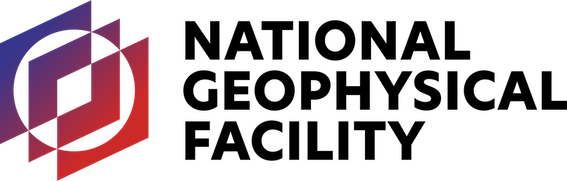
<!-- Image is embeded in this Markdown cell -->
<div style="display:flex; align-items:center; justify-content:space-between; gap:1rem;">
  <img src="attachment:NGF-Logo-FullName-RGB-Color.jpeg" style="max-height:120px;">
  <div style="text-align:right; line-height:1.25;">
    <h2 style="margin:0;">GNSS-IR Site Explorer Tool</h2>
    <p style="margin:0;">David Mencin</p>
    <p style="margin:0;"><em>© 2025 EarthScope Consortium</em></p>
  </div>
</div>

## GNSS-IR Site Visualzation Tool
This interactive tool visualizes the **Fresnel (glistening) zones** formed by GNSS signals reflecting off the ground or water surface near a GNSS antenna.  
It is designed to help evaluate whether a particular **site geometry** is suitable for **GNSS-Interferometric Reflectometry (GNSS-IR)** studies.

### What the Tool Does
- Given an **antenna height** \( h \), **satellite elevation** \( E \), and a range of **azimuths** \( A \),  
  the tool computes the **specular reflection point** and the corresponding **Fresnel zones** on the ground.
- Each Fresnel zone represents an area where **direct and reflected GNSS signals interfere** constructively or destructively.
- The **first Fresnel zone** dominates the reflection and defines the effective **glistening footprint** for GNSS-IR.

### How to Use It
1. Set the antenna’s location and height (`h`).
2. Adjust the satellite **elevation** and **azimuth range** (`Az start`, `Az end`, `Az step`).
3. Toggle **specular markers** to see the reflection points for each azimuth.
4. Optionally refine grid parameters (`N_para`, `k_pad`) to ensure the full Fresnel zone is captured.

### How to Interpret the Results
- The colored ellipses show the **footprint** of each satellite’s reflection on the ground.
- A **clear, unobstructed glistening zone** (e.g., over water or flat terrain) indicates a **good site** for GNSS-IR.
- Zones overlapping trees, buildings, or rough surfaces suggest **multipath interference** and **poor suitability**.
- By sweeping multiple azimuths, you can assess **which directions** offer the best reflective geometry.

In [3]:
# Interactive GNSS-IR glistening zone explorer (the intersection of the Fresnel ellipsoid and a reflector is the Fresnel zone
# the area of this is the glistening zone and the centrois the spectral refelction point
# EarthScope, DJM 2025

# Subroutines and constants
# Speed of Light
c = 299_792_458.0
# GPS signal freqeuncies 
WAVES = {"L1": c/1_575_420_000.0, "L2": c/1_227_600_000.0, "L5": c/1_176_450_000.0}

#routine to make different colors for each fresnel zone ideally this helps with visualization
# Experimental DJM 
def color_for_idx(i, total):
    import colorsys
    h = (i / max(1, total)) % 1.0
    r,g,b = colorsys.hsv_to_rgb(h, 0.9, 0.95)
    return "#%02x%02x%02x" % (int(255*r), int(255*g), int(255*b))


"""
    Heart of the program, reference:
    Zimmermann, F., Schmitz, B., Klingbeil, L. & Kuhlmann, H. GPS Multipath Analysis Using Fresnel Zones. Sensors 19, 25 (2018).
  
    Compute Fresnel-zone (glistening zone) footprints on the ground for a single satellite azimuth
    at a fixed elevation angle.

    Parameters
    ----------
    lat0 : float
        Antenna latitude in degrees (WGS84).

    lon0 : float
        Antenna longitude in degrees (WGS84).

    h : float
        Antenna phase-center height above the reflecting surface (meters).

    elev_deg : float
        Satellite elevation angle above the horizon (degrees).

    azim_deg : float
        Satellite azimuth clockwise from true north (degrees).

    lam : float
        GNSS carrier wavelength (meters); e.g., 0.1903 m for L1, 0.2442 m for L2, 0.2548 m for L5.

    n_zones : int
        Number of Fresnel zones (ΔL = n * λ / 2) to compute and return.

    aeqd : pyproj.CRS
        Local Azimuthal Equidistant (AEQD) projection centered at (lat0, lon0),
        used to convert geographic coordinates to local ENU meters.

    to_wgs84 : pyproj.Transformer
        Transformer object that converts from AEQD (meters) back to geographic (lon, lat)
        for plotting or export.

    k_pad : float, optional (default = 4.0)
        Padding factor that scales the computational domain size around the specular point.
        Increase if low-elevation satellites cause clipping of Fresnel zones.

    N_para : int, optional (default = 700)
        Grid resolution (number of samples) along the specular (satellite) direction.
        Larger values produce smoother contours but take longer.

    N_perp : int, optional (default = 300)
        Grid resolution across the specular direction (cross-track).

    Returns
    -------
    lon_sp : float
        Longitude (degrees) of the specular reflection point on the surface.

    lat_sp : float
        Latitude (degrees) of the specular reflection point on the surface.

    loops : list of np.ndarray
        One NumPy array per Fresnel level (or None if no contour found). Each array has shape (M, 2)
        in local (east, north) meters forming a closed loop (polygon) for that Fresnel zone.

    Notes
    -----
    - The specular point is toward the satellite at a horizontal range ρ = h * cot(E).
    - The domain is rotated and stretched to align with the specular direction, preventing
      Fresnel zones from being clipped when elevation is low.
    - Each contour corresponds to ΔL = n * λ / 2 for n = 1…`n_zones`.

"""
def fresnel_loops_for_azimuth(lat0, lon0, h, elev_deg, azim_deg, lam, n_zones,
                              aeqd, to_wgs84,
                              k_pad=4.0, N_para=700, N_perp=300):

    # Receiver height vector in local ENU coordinates
    R = np.array([0.0, 0.0, h])

    # Convert angles to radians
    E = math.radians(elev_deg) 
    A = math.radians(azim_deg)
    sinE = math.sin(E)

    # Unit vector from receiver toward satellite (sky direction)
    u = np.array([math.cos(E)*math.sin(A), math.cos(E)*math.cos(A), math.sin(E)])  # RX->SV
    uw = -u  # Wave propagates downward, opposite direction
    
    # Define local direction vectors in EN plane
    v_para = np.array([math.sin(A), math.cos(A)])     # toward SV on ground
    v_perp = np.array([math.cos(A), -math.sin(A)])    # 90° CCW from v_para

    # Specular point on ground (toward satellite)
    rho = h / max(1e-6, math.tan(E))
    r0 = np.array([rho*math.sin(A), rho*math.cos(A), 0.0])

    # Path-length function: incident wave + receiver path
    def L_value(x, y):
        r = np.array([x, y, 0.0])
        return np.dot(uw, r) + np.linalg.norm(R - r)
    
    # Reference total path at the specular point
    L0 = L_value(r0[0], r0[1])
    
    # Excess path relative to specular point
    def delta_L(x, y): return L_value(x, y) - L0

    # Fresnel scales & domain
    R_perp = math.sqrt(max(lam*h / max(1e-6, sinE), 1e-6))
    R_para = R_perp / max(1e-3, sinE)
    
    # Domain extents scaled by k_pad to avoid clipping
    L_perp = k_pad * R_perp * math.sqrt(max(1, n_zones))
    L_para = k_pad * R_para * math.sqrt(max(1, n_zones))

    # Build rotated anisotropic grid centered at specular point
    u_axis = np.linspace(-L_para, L_para, N_para)
    v_axis = np.linspace(-L_perp, L_perp, N_perp)
    UU, VV = np.meshgrid(u_axis, v_axis)
    XX = r0[0] + UU * v_para[0] + VV * v_perp[0]
    YY = r0[1] + UU * v_para[1] + VV * v_perp[1]

    # Evaluate excess path on grid
    # contours (Matplotlib 3.9+)
    # Contour levels at ΔL = n * λ / 2
    levels = [(n+0.0)*lam/2.0 for n in range(1, n_zones+1)]
    DL = np.vectorize(delta_L)(XX, YY)
    cs = plt.contour(XX, YY, DL, levels=levels)
    plt.close()

    # For each Fresnel level, pick the loop enclosing the specular point
    loops = []
    for segs in cs.allsegs:
        if not segs:
            loops.append(None); continue
        # pick segment whose centroid is closest to r0
        centroids = [np.mean(seg, axis=0) for seg in segs]
        d2 = [np.sum((c - r0[:2])**2) for c in centroids]
        best = segs[int(np.argmin(d2))]
        if not np.allclose(best[0], best[-1]):
            best = np.vstack([best, best[0]])
        loops.append(best)

    # Convert specular point to lon/lat for map display
    to_ll = Transformer.from_crs(aeqd, CRS.from_epsg(4326), always_xy=True)
    lon_sp, lat_sp = to_ll.transform(r0[0], r0[1])
    return (lon_sp, lat_sp, loops)

# UI defaults - use site SC02 (Friday Harbor, WA, USA) 
lat0_val, lon0_val = 48.5462, -123.0076
zoom_val = 18

# Map & projection
aeqd = CRS.from_proj4(f"+proj=aeqd +lat_0={lat0_val} +lon_0={lon0_val} +x_0=0 +y_0=0 +datum=WGS84 +units=m")
to_wgs84 = Transformer.from_crs(aeqd, CRS.from_epsg(4326), always_xy=True)

m = Map(center=(lat0_val, lon0_val), zoom=zoom_val, scroll_wheel_zoom=True)
m.add_layer(basemap_to_tiles(basemaps.Esri.WorldImagery))
ant_marker = Marker(location=(lat0_val, lon0_val))
m.add_layer(ant_marker)

layer_group = LayerGroup()
m.add_layer(layer_group)

# ---------------- Widgets ----------------
lat_w   = FloatText(value=lat0_val, description='Lat', layout=Layout(width='180px'))
lon_w   = FloatText(value=lon0_val, description='Lon', layout=Layout(width='180px'))
zoom_w  = BoundedIntText(value=zoom_val, min=1, max=22, description='Zoom', layout=Layout(width='150px'))

# SC02 (Friday Harbor, WA, USA) antenna ~5.5 m 
h_w     = FloatSlider(value=5.5, min=0.2, max=10.0, step=0.1, description='Height h (m)', readout_format='.1f', continuous_update=False)
elev_w  = FloatSlider(value=10.0, min=1.0, max=30.0, step=0.5, description='Elevation (°)', readout_format='.1f', continuous_update=False)
# Default to L2
band_w  = Dropdown(options=['L1','L2','L5'], value='L2', description='Band')
# Two zones (one is more than suffcient - but looks cooler)
zones_w = IntSlider(value=2, min=1, max=5, step=1, description='Zones', continuous_update=False)

a_start = BoundedIntText(value=40, min=0, max=359, description='Az start', layout=Layout(width='150px'))
a_end   = BoundedIntText(value=190, min=0, max=359, description='Az end', layout=Layout(width='150px'))
a_step  = BoundedIntText(value=10, min=1, max=90, description='Az step', layout=Layout(width='150px'))

markers_toggle = ToggleButton(value=False, description='Specular markers', icon='map-marker')
redraw_btn     = Button(description='Redraw', button_style='primary', icon='refresh')
status_html    = HTML('')

controls_row1 = HBox([lat_w, lon_w, zoom_w, band_w, zones_w])
controls_row2 = HBox([h_w, elev_w, a_start, a_end, a_step, markers_toggle, redraw_btn])

ui = VBox([controls_row1, controls_row2, status_html, m])
display(ui)

# Callback for UI
def redraw(*args):
    status_html.value = "Rendering…"
    # Update projection if lat/lon changed
    global aeqd, to_wgs84
    aeqd = CRS.from_proj4(f"+proj=aeqd +lat_0={lat_w.value} +lon_0={lon_w.value} +x_0=0 +y_0=0 +datum=WGS84 +units=m")
    to_wgs84 = Transformer.from_crs(aeqd, CRS.from_epsg(4326), always_xy=True)

    # Update map view & antenna marker
    m.center = (lat_w.value, lon_w.value); m.zoom = zoom_w.value
    ant_marker.location = (lat_w.value, lon_w.value)

    # Clear old layers
    for lyr in list(layer_group.layers):
        layer_group.remove_layer(lyr)

    lam = WAVES[band_w.value]
    az0, az1, daz = a_start.value % 360, a_end.value % 360, max(1, a_step.value)
    # Build azimuth list inclusively, handling wrap-around
    if az0 <= az1:
        az_list = list(range(az0, az1 + 1, daz))
    else:
        az_list = list(range(az0, 360, daz)) + list(range(0, az1 + 1, daz))

    # Precompute color ramp - Experimentat DJM
    colors = [color_for_idx(i, max(1, len(az_list))) for i in range(len(az_list))]
    n_z = zones_w.value

    # Grid/contour knobs (tweak if needed)
    k_pad = 4.0
    N_para, N_perp = 600, 260
    thin_max_pts = 350

    # Render each azimuth
    for i, Adeg in enumerate(az_list):
        lon_sp, lat_sp, loops = fresnel_loops_for_azimuth(
            lat_w.value, lon_w.value, h_w.value, elev_w.value, Adeg, lam, n_z,
            aeqd, to_wgs84, k_pad=k_pad, N_para=N_para, N_perp=N_perp
        )

        if markers_toggle.value:
            layer_group.add_layer(Marker(location=(lat_sp, lon_sp)))

        base_color = colors[i]
        for ring_idx, v in enumerate(loops, start=1):
            if v is None: continue
            step = max(1, len(v)//thin_max_pts)
            coords = []
            for x, y in v[::step]:
                lon_i, lat_i = to_wgs84.transform(x, y)
                coords.append((lat_i, lon_i))
            poly = Polygon(
                locations=coords,
                color=base_color,
                fill_color=base_color,
                fill_opacity=0.10 if ring_idx > 1 else 0.18,
                weight=2 if ring_idx == 1 else 1,
                name=f"Az {Adeg}°, zone {ring_idx}"
            )
            layer_group.add_layer(poly)

    status_html.value = f"Drew {len(az_list)} azimuth(s) at elevation {elev_w.value:.1f}° with {n_z} zone(s)."

# Wire events (use button to moderate heavy redraws)
redraw_btn.on_click(lambda b: redraw())

<h2 style="color:#2c3e50;">Qualities of a Good GNSS-IR Site</h2>

<p style="font-size:1.05em;">
Selecting an optimal site for <strong>GNSS Interferometric Reflectometry (GNSS-IR)</strong> requires balancing reflection geometry, environmental stability, and signal coherence.  
Below are the key characteristics that define an ideal GNSS-IR location:
</p>

<table style="width:100%; border-collapse:collapse; font-size:0.97em;">
  <thead style="background-color:#e9ecef; text-align:left;">
    <tr>
      <th style="padding:8px; border-bottom:2px solid #dee2e6;">Feature</th>
      <th style="padding:8px; border-bottom:2px solid #dee2e6;">Why it Helps GNSS-IR</th>
      <th style="padding:8px; border-bottom:2px solid #dee2e6;">Considerations</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px; vertical-align:top;"><strong>Large, unobstructed reflection zone</strong></td>
      <td style="padding:8px;">Allows many usable satellite arcs for reflection analysis.</td>
      <td style="padding:8px;">Aim for ≥ 90° of clear azimuth coverage—ideally ~180°. Avoid blockage by trees, hills, or buildings.</td>
    </tr>
    <tr>
      <td style="padding:8px; vertical-align:top;"><strong>Flat, smooth reflecting surface</strong></td>
      <td style="padding:8px;">Preserves coherence and simplifies Fresnel geometry.</td>
      <td style="padding:8px;">Calm water (lakes, reservoirs, tidal flats) is ideal. Avoid vegetation or rough surfaces.</td>
    </tr>
    <tr>
      <td style="padding:8px; vertical-align:top;"><strong>Minimal nearby obstructions</strong></td>
      <td style="padding:8px;">Prevents unwanted multipath and signal distortion.</td>
      <td style="padding:8px;">Keep objects (masts, cables) at least 1.5 m away from the antenna.</td>
    </tr>
    <tr>
      <td style="padding:8px; vertical-align:top;"><strong>Low elevation mask</strong></td>
      <td style="padding:8px;">Low-elevation signals create long path differences and stronger SNR oscillations.</td>
      <td style="padding:8px;">Do not restrict low-elevation satellites unless horizon clutter is severe.</td>
    </tr>
    <tr>
      <td style="padding:8px; vertical-align:top;"><strong>Appropriate antenna height</strong></td>
      <td style="padding:8px;">Controls reflection geometry and signal strength.</td>
      <td style="padding:8px;">Keep the antenna high enough to avoid flooding or snow cover, but not excessively high (reduces reflected power).</td>
    </tr>
    <tr>
      <td style="padding:8px; vertical-align:top;"><strong>Stable, fixed monument</strong></td>
      <td style="padding:8px;">Ensures consistent phase-center reference for long-term records.</td>
      <td style="padding:8px;">Bedrock or deep concrete footing preferred over flexible or floating mounts.</td>
    </tr>
    <tr>
      <td style="padding:8px; vertical-align:top;"><strong>High-quality GNSS receiver</strong></td>
      <td style="padding:8px;">More satellites and better SNR data → denser, cleaner interference patterns.</td>
      <td style="padding:8px;">Use multi-GNSS receivers that log SNR at ≤ 15 s intervals (ideally 1–10 s).</td>
    </tr>
    <tr>
      <td style="padding:8px; vertical-align:top;"><strong>Calm environmental conditions</strong></td>
      <td style="padding:8px;">Improves coherence of the reflected signal.</td>
      <td style="padding:8px;">Avoid strong winds or wave heights that exceed a few centimeters.</td>
    </tr>
    <tr>
      <td style="padding:8px; vertical-align:top;"><strong>Reference water-level sensor</strong></td>
      <td style="padding:8px;">Provides ground-truth for GNSS-IR-derived heights.</td>
      <td style="padding:8px;">Install or co-locate with a tide gauge, pressure transducer, or laser altimeter.</td>
    </tr>
  </tbody>
</table>

<hr style="border:none; border-top:1px solid #dee2e6; margin:1.2em 0;" />

<h4 style="color:#2c3e50;">References</h4>
<ul style="font-size:0.95em; line-height:1.5em;">
  <li>
    <a href="https://gnssrefl.readthedocs.io/en/latest/pages/new_station.html" target="_blank">
      GNSS-Reflections Documentation: “What is a Good GNSS Reflections Site?”
    </a>
  </li>
  <li>
    <a href="https://www.researchgate.net/publication/339178249_Site_guidelines_for_multi-purpose_GNSS_reflectometry_stations" target="_blank">
      Larson, K.M. et al., 2020 — <em>Site Guidelines for Multi-Purpose GNSS Reflectometry Stations</em>
    </a>
  </li>
</ul>

</div>